In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pll as pll
from functools import partial
from scipy.fft import fft, fftfreq
from scipy.signal import butter, sosfiltfilt, lfilter
from typing import Callable
from triggered_sampler import TriggeredSampler
import warnings
warnings.filterwarnings("error")
fs = np.int32(122.88e6)  # Sampling frequency

In [2]:
def to_complement(value: np.uint16) -> np.uint16:
    return np.uint16((np.uint32(value) + 0x8000) & 0xFFFF)

def sign_extend(value: np.uint16, bits: int = 24) -> np.uint32:
    if value & 0x8000:
        return np.uint32(np.uint32(value) | 0xFFFF0000) & (2**bits - 1)
    else:
        return np.uint32(np.uint32(value) & 0x0000FFFF) & (2**bits - 1)
    
def bv28to32s(value: np.uint32) -> np.uint32:
    if value & 0x08000000:
        return np.uint32(np.uint32(value | 0xF0000000))
    else:
        return np.uint32(np.uint32(value & 0x0FFFFFFF))
    
def add (a: np.uint32, b: np.uint32, bits: int = 24) -> np.uint32:
    a = a & (2**bits - 1)
    b = b & (2**bits - 1)
    return (a + b) & (2**bits - 1)

def negate (a: np.uint32, bits: int = 24) -> np.uint32:
    a = a & (2**bits - 1)
    return ((~a) + 1) & (2**bits - 1) if a != 0 else 0

In [3]:
def cic3d16gen(bits = 28) -> Callable[[np.uint16], tuple[np.uint16, np.uint16]]:
    int3_st  = [np.uint32(0) for _ in range(3)]
    comb3_st = [np.uint32(0) for _ in range(3)]
    sample_state: int = 0
    bits = bits

    def cic3d16(input_sample: np.uint16) -> tuple[np.uint16, np.uint16]:
        nonlocal int3_st, comb3_st, sample_state
        input_sample = sign_extend(input_sample, bits=bits)

        out1 = add(int3_st[0], input_sample, bits=bits)
        out2 = add(int3_st[1], out1, bits=bits)
        out3 = add(int3_st[2], out2, bits=bits)
        int3_st = [out1, out2, out3]

        diff1 = add(out3, negate(comb3_st[0], bits=bits), bits=bits)
        diff2 = add(diff1, negate(comb3_st[1], bits=bits), bits=bits)
        diff3 = add(diff2, negate(comb3_st[2], bits=bits), bits=bits)

        if sample_state == 0:
            comb3_st = [out3, diff1, diff2]
        
        ready = np.uint16(1) if sample_state==0 else np.uint16(0)
        sample_state = (sample_state + 1) % 16
        return (ready, np.uint16((diff3 >> (bits - 16)) & 0xFFFF))
    return cic3d16

def cic3u16gen(bits = 28) -> Callable[[np.uint16, np.uint16], np.uint16]:
    int3_st  = [np.uint32(0) for _ in range(3)]
    comb3_st = [np.uint32(0) for _ in range(3)]
    bits = bits

    def cic3u16(valid: np.uint16, input_sample: np.uint16) -> tuple[np.uint16, np.uint16]:
        nonlocal int3_st, comb3_st
        input_sample = sign_extend(input_sample, bits=bits)


        diff1 = add(input_sample, negate(comb3_st[0], bits=bits), bits=bits)
        diff2 = add(diff1, negate(comb3_st[1], bits=bits), bits=bits)
        diff3 = add(diff2, negate(comb3_st[2], bits=bits), bits=bits)

        if valid == 1:
            comb3_st = [input_sample, diff1, diff2]
        
        diff3 = diff3 if valid == 1 else np.uint32(0)

        out1 = add(int3_st[0], diff3, bits=bits)
        out2 = add(int3_st[1], out1, bits=bits)
        out3 = add(int3_st[2], out2, bits=bits)
        
        int3_st = [out1, out2, out3]
        
        return (np.uint16((out3 >> (bits - 20)) & 0xFFFF), bv28to32s(out1))
    return cic3u16

In [6]:
f1 = 2.5e6  # 2.5MHz signal frequency
tw1 = np.uint32((f1 / fs) * 2**24) # Tuning word
signal1 = partial(pll.nco_gen(initial_phase=0.2), tw1)

f2 = 10e6  # 10MHz signal frequency
tw2 = np.uint32((f2 / fs) * 2**24) # Tuning word
signal2 = partial(pll.nco_gen(initial_phase=0), tw2)

In [7]:
sample_length = 1200000

signal = np.zeros(sample_length, dtype=np.uint16)
sampled = np.zeros(sample_length, dtype=np.uint16)
valid = np.zeros(sample_length, dtype=np.uint16)
upsampled = np.zeros(sample_length, dtype=np.uint16)
diff3 = np.zeros(sample_length, dtype=np.uint32)

cic3d16 = cic3d16gen(bits=28)
cic3u16 = cic3u16gen(bits=28)

for i in range(sample_length):
    signal[i] = np.uint16(to_complement((signal1()) + 0*(signal2() >> 2)))
    (valid[i], sampled[i]) = cic3d16(signal[i])
    (upsampled[i], diff3[i]) = cic3u16(valid[i], sampled[i])

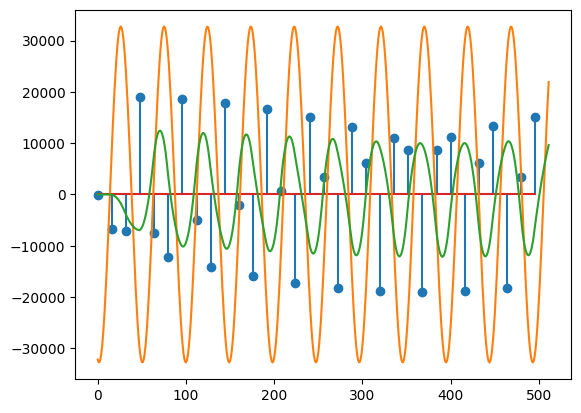

In [8]:
samples = 512
plt.stem(range(0, samples, 16), (sampled[0:samples:16] * valid[0:samples:16]).astype(np.int16), 'o')
plt.plot(signal[:samples].astype(np.int16))
plt.plot(upsampled[:samples].astype(np.int16))

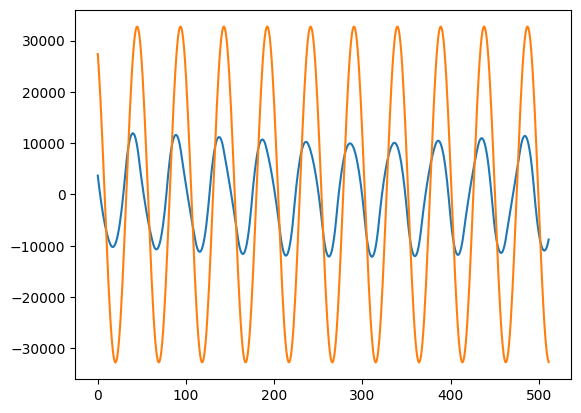

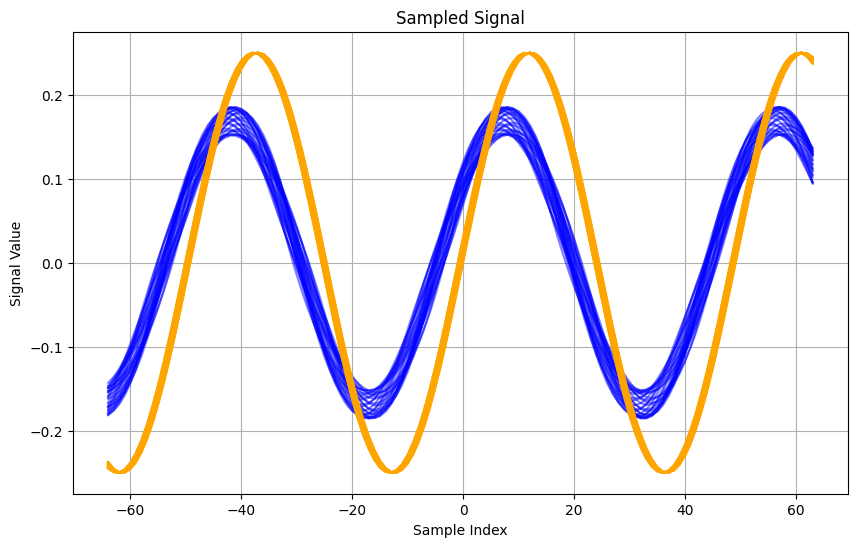

In [9]:
upsampled = upsampled.astype(np.int16)
signal = signal.astype(np.int16)
trigger = np.array([signal[i] != signal[i-1] and signal[i] > 0 and signal[i-1] < 0 for i in range(1, len(signal))], dtype=bool) 


plt.plot(upsampled[-samples:].astype(np.int16))
plt.plot(signal[-samples:].astype(np.int16))
plt.figure(figsize=(10, 6))
plt.grid()

upsampledSampler = TriggeredSampler(window_size=128, full_scale=(2**15-1), full_scale_volt=0.5)
signalSampler = TriggeredSampler(window_size=128, full_scale=(2**15-1), full_scale_volt=0.25)

upsampledSampler.sample(upsampled[-4096:].astype(np.int16), trigger[-4096:])
upsampledSampler.plot_sampled_signal(plt.gca())
    
signalSampler.sample(signal[-8192:].astype(np.int16), trigger[-8192:])
signalSampler.plot_sampled_signal(plt.gca(), color="orange")